# Проект "Компьютер говорит нет"

# Задача проекта.

Построить модель для клиентов банка, которая бы предсказывала вероятность дефолта клиента. 

# Импорт библиотек.

In [1]:
from pandas import Series
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

from datetime import date
from datetime import datetime, timedelta

Зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:

In [2]:
!pip freeze > requirements.txt

# Загрузка данных.

In [3]:
PATH_to_file = '/kaggle/input/sf-dst-scoring/'
df_train = pd.read_csv(PATH_to_file+'train.csv')
df_test = pd.read_csv(PATH_to_file+'test.csv')

Обучающие и тестовые данные оставим изолированными для более корректной работы модели.

In [4]:
df_train.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
14241,52853,01MAR2014,SCH,F,45,N,N,0,0,-1.609917,0,40,1,2,20000,1,3,N,1
6744,84116,01APR2014,GRD,F,44,N,N,0,0,-2.164609,0,50,2,3,25000,1,4,N,0
8187,73414,21MAR2014,SCH,F,25,N,N,0,0,-2.042540,3,40,1,2,25000,2,2,Y,1
25513,61240,10MAR2014,UGR,F,22,N,N,6,1,-0.758697,2,70,2,3,35000,4,2,N,1
22357,52050,28FEB2014,GRD,F,31,Y,Y,0,0,-1.204858,2,80,2,3,800000,4,2,Y,0


In [5]:
df_test.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
25847,105611,24APR2014,GRD,M,28,N,N,1,0,-1.456430,4,80,2,3,70000,1,1,N
35027,46446,22FEB2014,SCH,F,21,N,N,1,0,-1.227121,0,70,2,3,30000,1,1,N
1810,91327,07APR2014,GRD,F,46,N,N,0,0,-2.447239,2,50,1,2,15000,1,4,Y
33094,79848,27MAR2014,GRD,M,30,Y,N,0,0,-2.094429,0,50,1,2,41000,2,3,N
9081,200,02JAN2014,UGR,F,28,N,N,3,0,-1.348326,25,40,1,2,45000,2,3,N


### Описание признаков:  
client_id - идентификатор клиента  
education - уровень образования  
sex - пол заемщика  
age - возраст заемщика  
car - флаг наличия автомобиля  
car_type - флаг автомобиля иномарки  
decline_app_cnt - количество отказанных прошлых заявок  
good_work - флаг наличия “хорошей” работы  
bki_request_cnt - количество запросов в БКИ  
home_address - категоризатор домашнего адреса   
work_address - категоризатор рабочего адреса  
income - доход заемщика  
foreign_passport - наличие загранпаспорта  
sna - связь заемщика с клиентами банка  
first_time - давность наличия информации о заемщике  
score_bki - скоринговый балл по данным из БКИ  
region_rating - рейтинг региона  
app_date - дата подачи заявки  
default - флаг дефолта по кредиту  

# Первичный анализ данных

Посмотрим на пропуски в данных:

In [6]:
df_train.isnull().sum()

client_id             0
app_date              0
education           307
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
dtype: int64

In [7]:
df_test.isnull().sum()

client_id             0
app_date              0
education           171
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
dtype: int64

Видим пропуски в графе образование в обоих датасетах, сразу заполним их самым популярным значением

In [8]:
df_train['education'].value_counts()

SCH    38860
GRD    23365
UGR     9816
PGR     1257
ACD      194
Name: education, dtype: int64

In [9]:
df_test['education'].value_counts()

SCH    19138
GRD    11403
UGR     4932
PGR      608
ACD       97
Name: education, dtype: int64

In [10]:
df_train['education'].fillna('SCH', inplace=True)
df_test['education'].fillna('SCH', inplace=True)

Теперь посмотрим на корреляцию между признаками:

<AxesSubplot:>

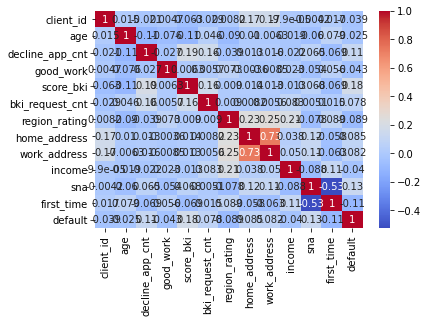

In [11]:
sns.heatmap(df_train.corr(), annot = True, cmap = 'coolwarm')

<AxesSubplot:>

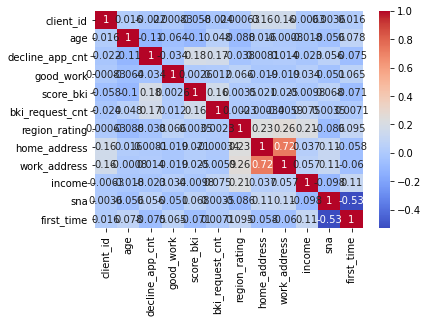

In [12]:
sns.heatmap(df_test.corr(), annot = True, cmap = 'coolwarm')

### Вывод.

Достаточно высокая корреляция между признаками: "home_address" с "work_address" и "sna" с "first_time"

# Анализ и обработка признаков

Рассмотрим признак "app_date"

In [13]:
df_train.app_date.sample(5)

66332    20FEB2014
31044    17MAR2014
51108    08FEB2014
30141    20JAN2014
51991    17JAN2014
Name: app_date, dtype: object

Приведем признак к формату datatime

In [14]:
df_train['app_date'] = df_train['app_date'].apply(lambda x: datetime.strptime(x, '%d%b%Y'))
df_test['app_date'] = df_test['app_date'].apply(lambda x: datetime.strptime(x, '%d%b%Y'))

Создадим новый признак на его основе - количество дней с момента подачи заявки. Для начала определим сегоднящную дату

In [15]:
current_date = pd.to_datetime('14JUN2021')

Теперь посчитаем количество дней с подачи заявки:

In [16]:
df_train['days'] = (current_date - df_train.app_date).dt.days
df_test['days'] = (current_date - df_test.app_date).dt.days

Переменная "app_date" теперь нам больше не нужна, можно её удалить

In [17]:
df_train.drop(['app_date'], inplace = True, axis =1)
df_test.drop(['app_date'], inplace = True, axis =1)

Теперь разделим данные на:  числовые, бинарные и категориальные:

In [18]:
# числовые признаки
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'score_bki', 'region_rating', 'days']

# бинарные признаки
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

# категориальные признаки
cat_cols = ['education', 'work_address', 'home_address', 'sna', 'first_time']

### Числовые признаки.

Посмотрим на графики распределения в обучающем датасете:

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


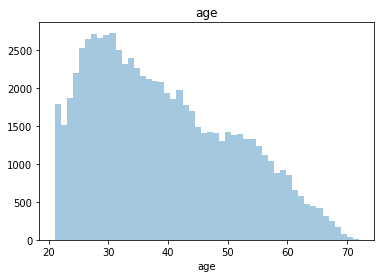

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


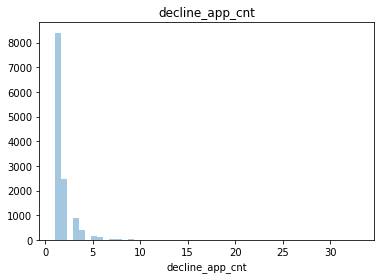

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


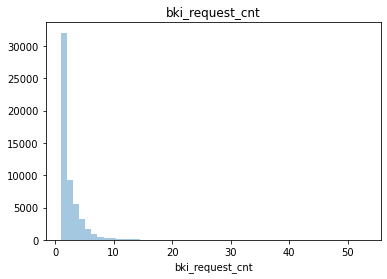

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


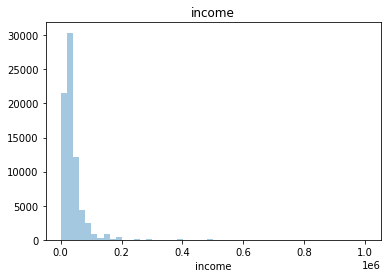

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


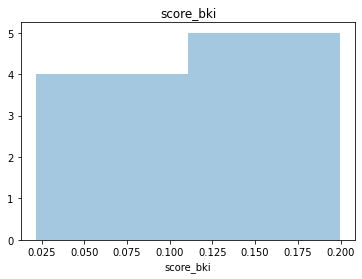

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


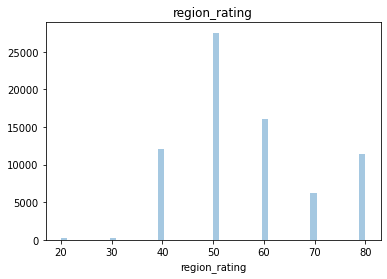

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


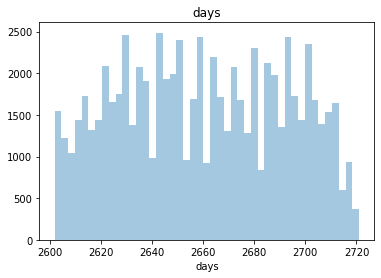

In [19]:
for i in num_cols:
    plt.figure()
    sns.distplot(df_train[i][df_train[i] > 0].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

Теперь посмотрим на тестовую выборку:

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


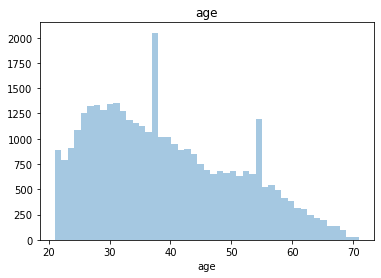

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


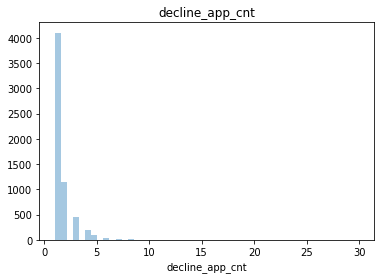

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


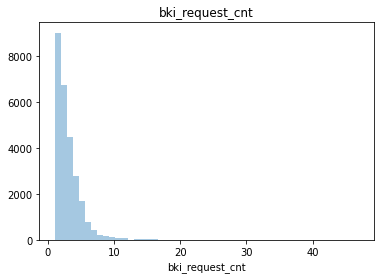

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


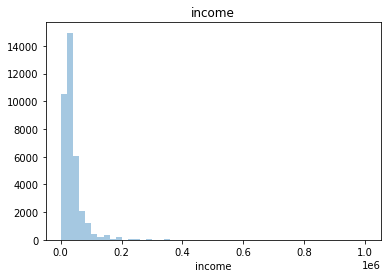

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


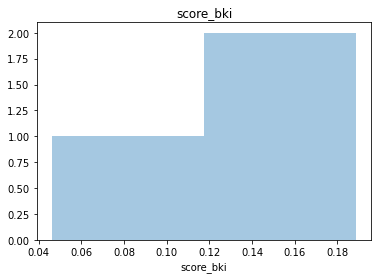

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


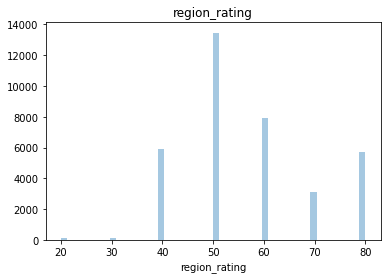

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


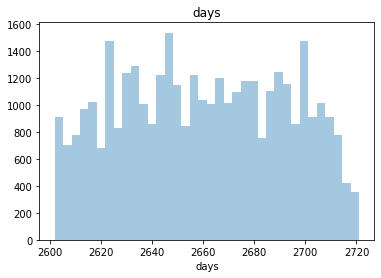

In [20]:
for i in num_cols:
    plt.figure()
    sns.distplot(df_test[i][df_test[i] > 0].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

Видим смещение показателей в некоторых признаках, прологарифмируем их

In [21]:
num_cols_log = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']

for i in num_cols_log:
    df_train[i] = np.log(df_train[i] + 1)

for i in num_cols_log:
    df_test[i] = np.log(df_test[i] + 1)

### Бинарные признаки.

Теперь рассмотрим распределение бинарных признаков и наличие неестественных показателей в обучающем датасете

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


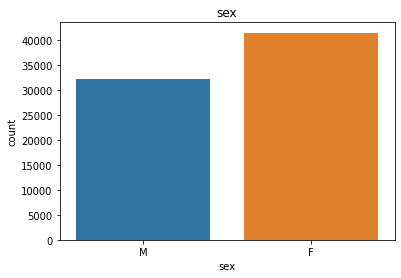

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


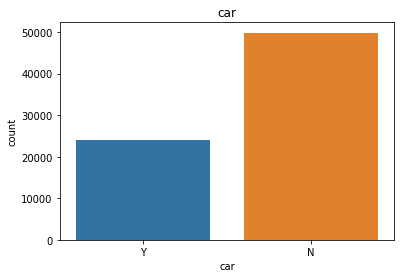

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


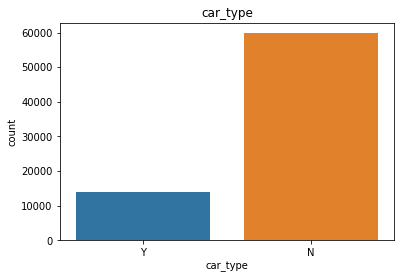

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


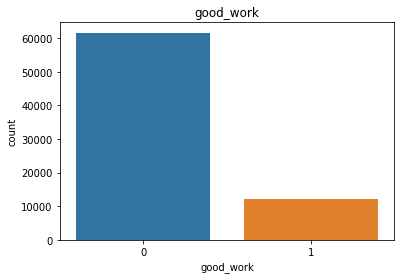

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


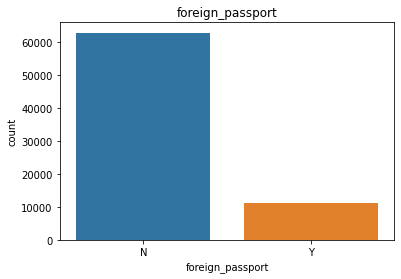

In [22]:
for column in bin_cols:
    plt.figure()
    sns.countplot(df_train[column])
    plt.title(column)
    plt.show()

И в тестовом

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


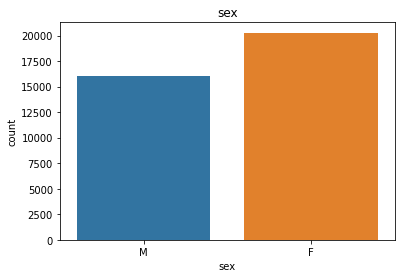

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


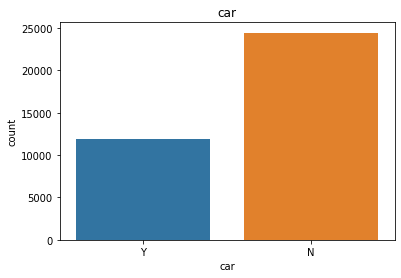

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


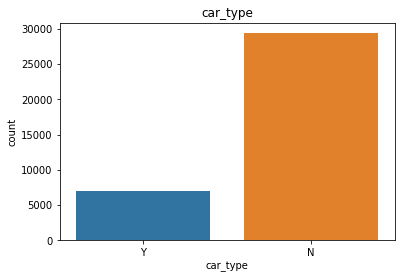

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


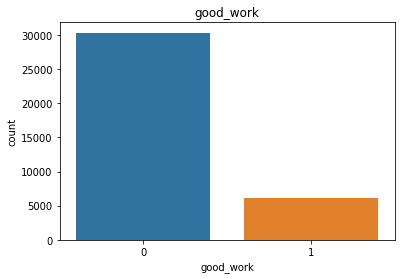

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


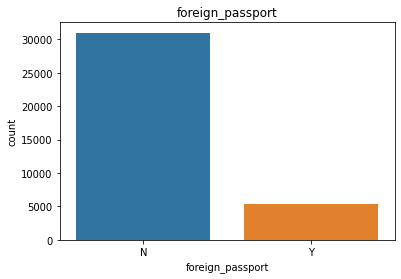

In [23]:
for column in bin_cols:
    plt.figure()
    sns.countplot(df_test[column])
    plt.title(column)
    plt.show()

### Вывод
Данные в обучющей и тестовой тамблице распределены пропорционально. Кредит чаще просят женщины, люди без автомобиля с плохой работой и без загран паспорта. Неестественных показателей в данных нет. 

### Категориальные признаки

Вначале рассмотрим обучающий датасет

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


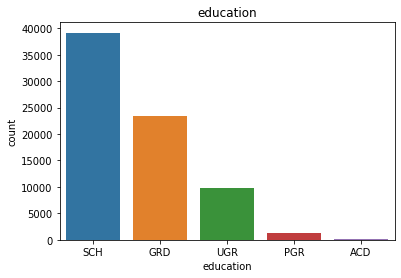

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


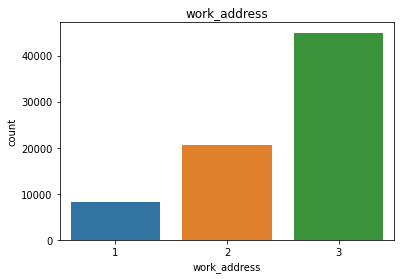

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


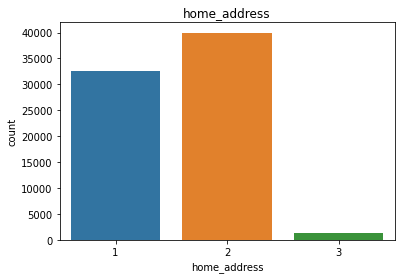

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


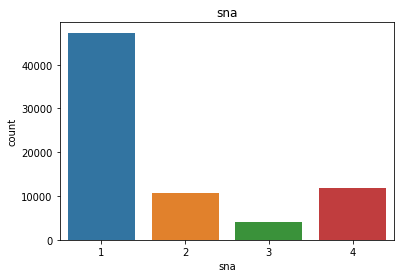

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


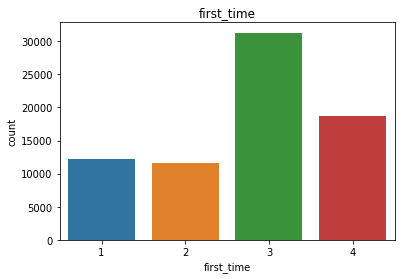

In [24]:
for column in cat_cols:
    plt.figure()
    sns.countplot(df_train[column])
    plt.title(column)
    plt.show()

Теперь тестовый

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


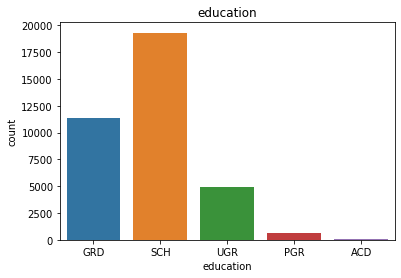

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


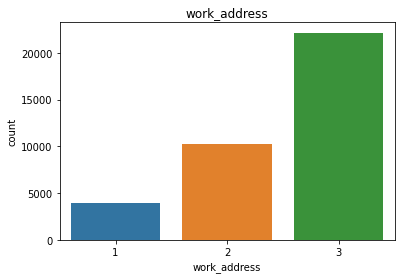

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


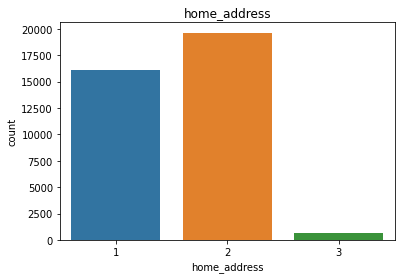

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


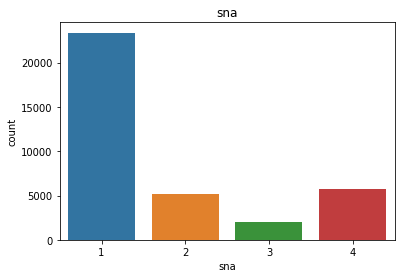

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


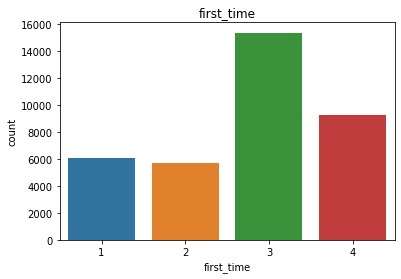

In [25]:
for column in cat_cols:
    plt.figure()
    sns.countplot(df_test[column])
    plt.title(column)
    plt.show()

### Вывод

Данные в обоих датасетах распределены пропорционально.

# Преобразование признаков

Преобразование бинарных признаков сделаем с помощью LabelEncoder

In [26]:
label_encoder = LabelEncoder()
for column in bin_cols:
    df_train[column] = label_encoder.fit_transform(df_train[column])
    print(dict(enumerate(label_encoder.classes_)))
for column in bin_cols:
    df_test[column] = label_encoder.fit_transform(df_test[column])
    print(dict(enumerate(label_encoder.classes_)))

{0: 'F', 1: 'M'}
{0: 'N', 1: 'Y'}
{0: 'N', 1: 'Y'}
{0: 0, 1: 1}
{0: 'N', 1: 'Y'}
{0: 'F', 1: 'M'}
{0: 'N', 1: 'Y'}
{0: 'N', 1: 'Y'}
{0: 0, 1: 1}
{0: 'N', 1: 'Y'}


Теперь перобразуем категориальные признаки. 
Начнем с параметра "education" т.к. в нем используются буквенные обозначения

In [ ]:
df_train['education'] = label_encoder.fit_transform(df_train['education'])
print(dict(enumerate(label_encoder.classes_)))

df_test['education'] = label_encoder.fit_transform(df_test['education'])
print(dict(enumerate(label_encoder.classes_)))

Посмотрим на значимость разных признаков. Начнем с числовых

In [ ]:
imp_num = pd.Series(f_classif(df_train[num_cols], df_train['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Бинарные признаки

In [ ]:
imp_cat = pd.Series(f_classif(df_train[cat_cols], df_train['default'])[0], index = cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [ ]:
imp_bin = pd.Series(f_classif(df_train[bin_cols], df_train['default'])[0], index = bin_cols)
imp_bin.sort_values(inplace = True)
imp_bin.plot(kind = 'barh')

Теперь на основе этих данных добавим нове принзнаки

In [ ]:
df_train['bki_age_reg'] = (df_train['score_bki']/df_train['age'])*df_train['region_rating']
df_test['bki_age_reg'] = (df_test['score_bki']/df_test['age'])*df_test['region_rating']

df_train['mult_sna_ftime'] = df_train['sna'] * df_train['first_time']
df_test['mult_sna_ftime'] = df_test['sna'] * df_test['first_time']

df_train['edu_and_income'] = (df_train['education'] + 1) * df_train['income']
df_test['edu_and_income'] = (df_test['education'] + 1) * df_test['income']

df_train['good_client'] = (df_train['foreign_passport'] + 1) * (df_train['good_work'] + 1) * (df_train['car'] + 1)
df_test['good_client'] = (df_test['foreign_passport'] + 1) * (df_test['good_work'] + 1) * (df_test['car'] + 1)

df_train['fpassp_and_gwork'] = df_train['foreign_passport'] * df_train['good_work'] 
df_test['fpassp_and_gwork'] = df_test['foreign_passport'] * df_test['good_work']

df_train['fpassp_and_car'] = df_train['foreign_passport'] * df_train['car']
df_test['fpassp_and_car'] = df_test['foreign_passport'] * df_test['car']

Добавим новые признаки в соответсвующие списки

In [ ]:
num_cols.append('bki_age_reg')
num_cols.append('mult_sna_ftime')
num_cols.append('edu_and_income')
cat_cols.append('good_client')
bin_cols.append('fpassp_and_gwork')
bin_cols.append('fpassp_and_car')

Посмотри на значимость новых признаков

In [ ]:
imp_num = pd.Series(f_classif(df_train[num_cols], df_train['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [ ]:
imp_cat = pd.Series(f_classif(df_train[cat_cols], df_train['default'])[0], index = cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [ ]:
imp_bin = pd.Series(f_classif(df_train[bin_cols], df_train['default'])[0], index = bin_cols)
imp_bin.sort_values(inplace = True)
imp_bin.plot(kind = 'barh')

### Вывод

Добавили несколько новых признаков, которые не плохо связаны с целевой переменной. Так же преобразовали бинарные и категориальные признаками, в дальнейшем нам это пригодится для обучения модели

# Подготовка данных к обучению

С помощью OneHotEncoder преобразуем категориальные признаки

In [ ]:
X_cat = OneHotEncoder(sparse = False).fit_transform(df_train[cat_cols].values)
Y_cat = OneHotEncoder(sparse = False).fit_transform(df_test[cat_cols].values)

Теперь стандартизируем числовые переменные

In [ ]:
X_num = StandardScaler().fit_transform(df_train[num_cols].values)
Y_num = StandardScaler().fit_transform(df_test[num_cols].values)

Объединим

In [ ]:
X = np.hstack([X_num, df_train[bin_cols].values, X_cat])
Y = df_train['default'].values

id_test = df_test['client_id']
test = np.hstack([Y_num, df_test[bin_cols].values, Y_cat])

Разделяем обучающую выборку на тренировочную и валидационную

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle = True)

Подберем гиперпараметры для нашей модели

In [ ]:
# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression()
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

### Вывод.

Подготовили данные для обучения, разделили обучающую выборку на тренировочную и валидационную и подобрали гиперпараметры для нашей модели.

# Обучение

Обучим модель с установленными гиперпараметрами

In [ ]:
model = LogisticRegression(class_weight='balanced', 
    max_iter = 1000,
    random_state=42)
model.fit(X_train, y_train)

Предскажем значение валидационных и тестовых данных

In [ ]:
Y_predict = model.predict(X_valid)
Y_predict_prob = model.predict_proba(X_valid)[:,1]

y_pred_test = model.predict(test)
y_pred_prob_test = model.predict_proba(test)[:,1]

In [ ]:
fpr, tpr, threshold = roc_curve(y_valid, Y_predict_prob)
roc_auc = roc_auc_score(y_valid, Y_predict_prob)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Посмотрим на Confusion matrix

In [ ]:
confusion_matrix(y_valid, Y_predict)

Обучим модель на всей обучающей базе

In [ ]:
main_model = LogisticRegression(class_weight='balanced',
    max_iter = 1000,
    random_state=42)
main_model.fit(X, Y)

Предсказываем значения тестовых данных

In [ ]:
y_pred_test = main_model.predict(test)
y_pred_prob_test = main_model.predict_proba(test)[:,1]

Создадим экземпляр таблицы с предсказаниями

In [ ]:
my_submission = pd.DataFrame({'client_id': id_test,
                              'default': y_pred_prob_test})
my_submission.to_csv('submission.csv', index=False)
my_submission.head()